In [1]:
#Link to dataset: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset

In [2]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
                'mask' : []
                }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)

    names = []
    maskNames = []
    unames = []

    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])

    unames = list(set(unames))

    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [4]:
# loading benign and malignant samples
framObjTrain = LoadData( framObjTrain, imgPath = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/malignant'
                         , maskPath = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/malignant'
                         , shape = 256)


framObjTrain = LoadData( framObjTrain, imgPath = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/benign'
                         , maskPath = '/Users/syn/Documents/GitHub/KidneySegmentation/Dataset_BUSI_with_GT/benign'
                         , shape = 256)

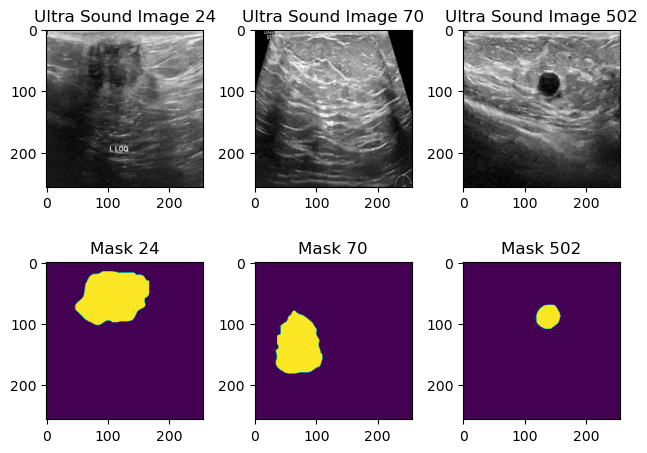

In [5]:
for i in range(3):
    index = random.randint(0, len(framObjTrain['img'])-1)  # generate a random index
    plt.subplot(2, 3, i+1)
    gray_image = plt.imshow(framObjTrain['img'][index], cmap='gray')
    plt.title(f'Ultra Sound Image {index+1}')

    plt.subplot(2, 3, i+4)
    plt.imshow(framObjTrain['mask'][index])
    plt.title(f'Mask {index+1}')

plt.tight_layout()
plt.show()

In [6]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                               kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                               kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x


# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [7]:
# Define dice coefficient metric function
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2.0 * intersection + smooth) / (union + smooth))
    return dice

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1.0 - score

In [8]:
# Define model
from tensorflow.keras.optimizers import Adam
optimizer_variable = Adam(lr=0.00005)
inputs = tf.keras.layers.Input((256, 256, 3))
mymodel = GiveMeUnet(inputs, droupouts=0.12)
mymodel.compile(optimizer='Adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])

/Users/syn/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Metal device set to: Apple M1 Max


In [13]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
results = mymodel.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']),
                  epochs=50, batch_size=32, verbose=1,
                  validation_split=0.2, callbacks=[early_stop, model_checkpoint])


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9536 - dice_coefficient: 0.6553
Epoch 1: val_loss improved from inf to 0.41446, saving model to best_weights.h5
17/17 [==============================] - 5s 301ms/step - loss: 0.2483 - accuracy: 0.9536 - dice_coefficient: 0.6553 - val_loss: 0.4145 - val_accuracy: 0.9374 - val_dice_coefficient: 0.5608
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9563 - dice_coefficient: 0.6828
Epoch 2: val_loss did not improve from 0.41446
17/17 [==============================] - 5s 278ms/step - loss: 0.2306 - accuracy: 0.9563 - dice_coefficient: 0.6828 - val_loss: 0.4510 - val_accuracy: 0.9232 - val_dice_coefficient: 0.5757
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9577 - dice_coefficient: 0.6814
Epoch 3: val_loss did not improve from 0.41446
17/17 [==============================] - 5s 278ms/step - loss: 0.2311 - accuracy: 0.9

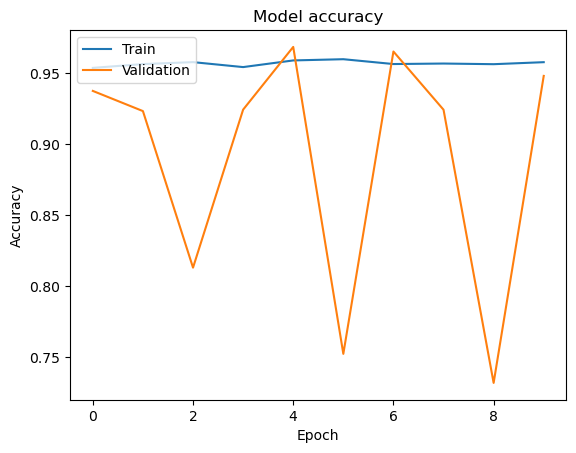

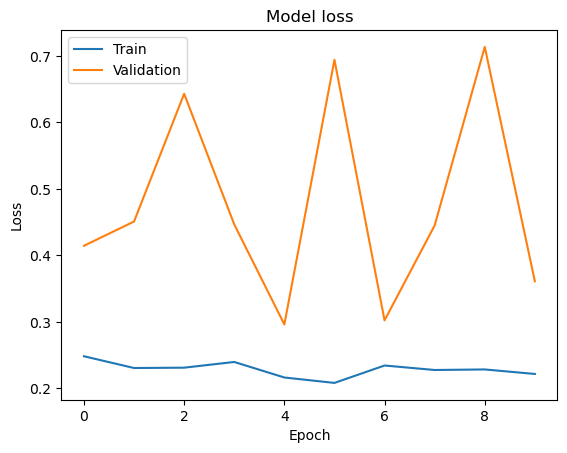

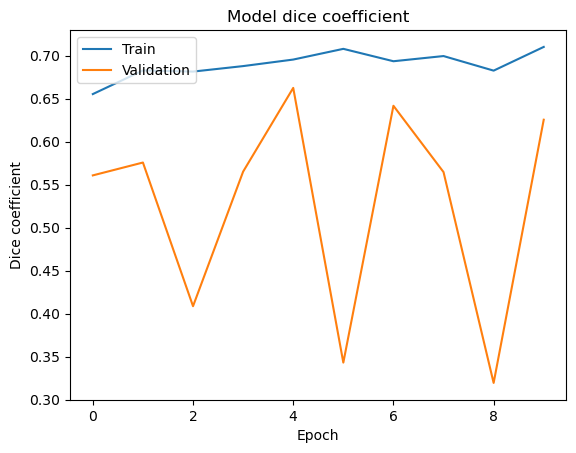

In [14]:
# print(results.history.values())
# loss, accuracy, iou, val_loss, val_accuracy = results.history.values()
# plt.figure(figsize=(20,8))

# plt.subplot(1,3,1)
# plt.title("Model Loss")
# plt.plot(loss, label="Training")
# plt.plot(val_loss, label="Validtion")
# plt.legend()
# plt.grid()

# plt.subplot(1,3,2)
# plt.title("Model Accuracy")
# plt.plot(accuracy, label="Training")
# plt.plot(val_accuracy, label="Validtion")
# plt.legend()
# plt.grid()

history = mymodel.history
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation dice coefficient
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [15]:
def predictions (valMap, model, shape = 256):
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    imgProc = img [0:16]
    imgProc = np.array(img)
    predictions = model.predict(imgProc)
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')


1/1 [==============================] - 0s 25ms/step


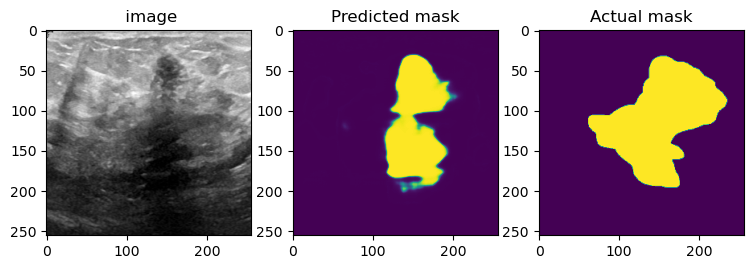

In [16]:
prediction_out, actuals, masks = predictions(framObjTrain, mymodel)
Plotter(actuals[1], prediction_out[1][:,:,0], masks[1])